# Model Server Demo

This notebook demonstrates how to receive simulations from the server.

In [10]:
import requests
import json
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

In [11]:
def dec_img(response):
    """Decode numpy array from base64 encoded response"""
    import base64
    from io import BytesIO
    
    result = response.json()
    
    # Check for content field (from get_df endpoint)
    if 'content' in result:
        # Decode base64 to bytes
        content_bytes = base64.b64decode(result['content'])
        # Load numpy array from bytes
        return np.load(BytesIO(content_bytes))
    elif 'image' in result:
        # Decode base64 image
        img_data = base64.b64decode(result['image'])
        img = Image.open(BytesIO(img_data))
        return np.array(img)
    elif 'matrix' in result:
        # Return matrix as numpy array
        return np.array(result['matrix'])
    else:
        print("No content, image, or matrix found in response")
        return None

print("✅ Helper function loaded")

✅ Helper function loaded


## Server Configuration

In [20]:
# Server configuration
SERVER_URL = "https://lux-server-jia3y72oka-ma.a.run.app" #"http://localhost:8081"

# Asset paths
SAMPLE_IMAGE_PATH = "../assets/sample.png"
RES_IMAGE_PATH = "../assets/res.png"
VALUES_NPY_PATH = "../assets/values.npy"

## Check Server Status

In [25]:
# Check if server is running
try:
    response = requests.get(f"{SERVER_URL}/")
    if response.status_code == 200:
        status = response.json()
        print("Server Status:")
        print(json.dumps(status, indent=2))
    else:
        print(f"Server returned status code: {response.status_code}")
except requests.exceptions.ConnectionError:
    print("❌ Server is not running. Please start the server first with: python src/main.py")
except Exception as e:
    print(f"❌ Error connecting to server: {e}")

Server Status:
{
  "services": {
    "colormanage_service": "ready",
    "daylight_service": "ready",
    "df_eval_service": "ready",
    "http_client": "ready",
    "orchestration_service": "ready"
  },
  "status": "running"
}


## Example Requests

### 🫧 get_df - Get Daylight Factor from Image

In [26]:
# Send get_df request
with open(SAMPLE_IMAGE_PATH, "rb") as f:
    files = {"file": ("sample.png", f)}
    df_response = requests.post(
        f"{SERVER_URL}/get_df",
        files=files,
        data={
            "translation": json.dumps({"x": 15 * 50, "y": 0 * 50}),
            "rotation": json.dumps([0])
        }
    )

df_result = dec_img(df_response)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


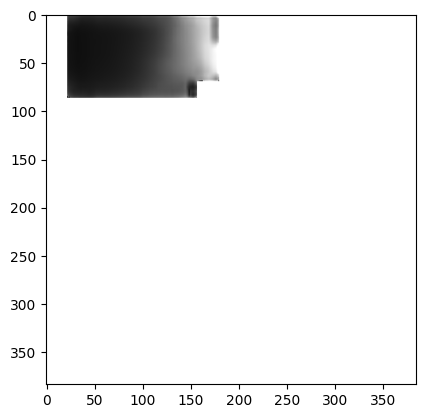

In [27]:
plt.imshow(df_result, cmap='viridis')

### 🫧 to_rgb 
##### Convert Values to RGB

In [28]:
# Send to_rgb request
values_data = np.load(VALUES_NPY_PATH)
rgb_response = requests.post(
    f"{SERVER_URL}/to_rgb",
    json={"data": values_data.tolist(), "colorscale": "df"}
)

rgb_result = np.array(rgb_response.json()["data"])

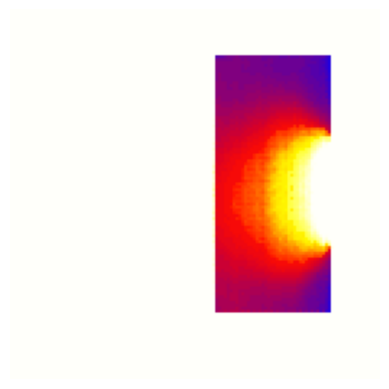

In [29]:
# Visualize result
plt.imshow(rgb_result)
plt.axis('off')
plt.show()

### 🫧 to_values 
##### Conversion of RGB into raw values


In [30]:
res_img = Image.open(RES_IMAGE_PATH)
res_array = np.array(res_img)

values_response = requests.post(
    f"{SERVER_URL}/to_values",
    json={"data": res_array.tolist(), "colorscale": "df"}
)

values_result = np.array(values_response.json()["data"])

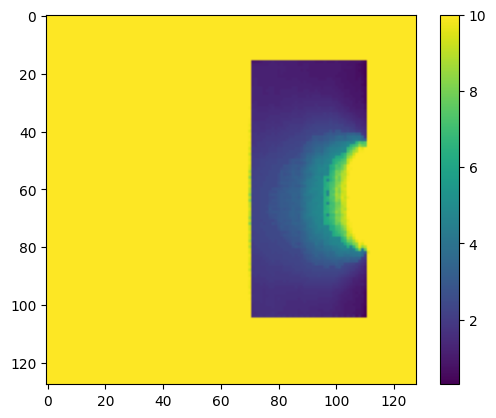

In [31]:
# Visualize result
plt.imshow(values_result, cmap='viridis')
plt.colorbar()
plt.show()

### 🫧 get_stats 
##### get statistics

In [32]:
# Send get_stats request
stats_response = requests.post(
    f"{SERVER_URL}/get_stats",
    json={"data": values_data.tolist()}
)

stats_result = stats_response.json()

In [33]:
# Display result
print(json.dumps(stats_result, indent=2))

{
  "error": "403 Client Error: Forbidden for url: https://df-eval-server-jia3y72oka-ma.a.run.app/get_stats",
  "status": "error"
}
